#### Project Details
Your tasks in this project are as follows:
-  Data wrangling, which consists of:
-  Gathering data
-  Assessing data
-  Cleaning data
-  Storing, analyzing, and visualizing your wrangled data
-  Reporting on 1) your data wrangling efforts and 2) your data analyses and visualizations

In [2]:
import pandas as pd
import numpy as np
import tweepy
import requests
import os
from io import StringIO
import json

### Step 1: Data Gathering
Gather the three pieces of data:
- The WeRateDogs Twitter archive (manually) - twitter-archive-enhanced.csv
- The tweet image predictions (programmatically) - image_predictions.tsv
- Additional data from the tweet using the Twitter API 

In [3]:
# Get the first piece of data -  WeRateDogs Twitter archive - contains basic tweet data 
# for all 5000+ tweets. 
# The text column was used to extract rating, dog name, and dog "stage" 
#(doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." 
# The tweets have been filtered for tweets with ratings only (there are 2356).
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head(2) #check it loaded correctly

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [4]:
# Get the second piece of data - tweet image predictions
# contains predictions of dog breed in each tweet according to a neural network. 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url).text                      

In [5]:
df_image_predictions = pd.read_csv(StringIO(response),sep='\t')

In [6]:
# write it out so I have a local copy of the file
df_image_predictions.to_csv('image-predictions.tsv', index=False)

In [7]:
#Check it loaded correctly
df_image_predictions.head(2) #Check it loaded correctly

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [ ]:
# Get the final piece of data - additional data for the tweets using the API.

# Using the tweet IDs in the WeRateDogs Twitter archive 
#    Query the Twitter API for each tweet's JSON data using Tweepy 
#    Write each tweet's entire set of JSON data to a file called tweet_json.txt file  
#    Each tweet's JSON data should be written to its own line. 
#    Read this .txt file line by line into a pandas DataFrame with (min) tweet ID, 
# retweet count, and favorite count.

In [6]:
#I have saved my keys and tokens as envinronment variables so they are hidden.  

consumer_key = os.environ.get('CONSUMER_KEY')
consumer_secret = os.environ.get('CONSUMER_SECRET')
access_token = os.environ.get('ACCESS_TOKEN')
access_secret = os.environ.get('ACCESS_SECRET')

#create API object to use to gather Twitter data.
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [7]:
# create list of all ids from df_archive
id_list = df_archive['tweet_id']

In [ ]:
import time
# Query the Twitter API for each tweet's JSON data using Tweepy 
# Write each tweet's entire set of JSON data to tweet_json.txt, each on its own line.
count = 0
with open('tweet_json.txt', mode='w') as file:
    # loop through every id in the archive
    for id in id_list:
        count +=1
        try:
            # get the data using the id
            status = api.get_status(id, tweet_mode='extended')
            # time the process
            start = time.clock()
            json.dump(status._json,file)
            file.write("\n")
            print(count, ": ", id, ": written", time.clock() - start)
        except tweepy.TweepError as e:
            # some of the tweets have been deleted
            print(id, ": fail")
            continue

In [8]:
with open('tweet_json.txt','r') as file: 
    tweet = file.readline() 

In [9]:
tweet_list = []

# Read file line by line into a pandas DataFrame storing tweet ID, retweet count, 
#and favorite count.
with open('tweet_json.txt','r') as file: 
    tweet = file.readline() #fixes issue as discussed on slack community 
    while tweet: # while still lines to read
        json_tweet = json.loads(tweet)
        tweet_list.append({'created_at':json_tweet['created_at'],
                           'id':json_tweet['id'],
                           #'followers_count':json_tweet['followers_count'],
                           #'friends_count':json_tweet['friends_count'],
                           'retweet_count':json_tweet['retweet_count'],
                           'favorite_count':json_tweet['favorite_count']
                          })                         
        tweet = file.readline() 
        
colnames = ['id','retweet_count','favorite_count','created_at']         
df_api_data = pd.DataFrame(tweet_list,columns=colnames)

In [10]:
#Check it loaded correctly
df_api_data.head(2)

,id,retweet_count,favorite_count,created_at
0,892420643555336193,8376,38236,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,6184,32780,Tue Aug 01 00:17:27 +0000 2017


### Step 2: Data Assessing
-  Assess the 3 sources visually and programmatically for quality and tidiness issues. 
-  Detect and document at least eight (8) quality issues and two (2) tidiness issues Notebook. 
-  The issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.
-   Ensure only original ratings (no retweets) that have images. 

#### Quality dimensions
-  Completeness (missing records/cells)
-  Validity (does it meet schema/do the values make sense for the columns?
-  Accuracy (do some values just look wrong?
-  Consistency (is there a mix of different values in same columns)
    
#### Tidiness
-  One variable per column ( ensure not multiple pieces of info in one column)
-  One obervation per row (ensure not duplicated records, maybe with different ids, or different spellings)
-  One unit per table 

In [11]:
# To enable viewing of longer text fields
pd.set_option('display.max_colwidth', 200)

In [12]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
# view 20 rows of archive dataframe
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2320,666437273139982337,NaN,NaN,2015-11-17 02:06:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we see a lone northeastern Cumberbatch. Half ladybug. Only builds with bricks. Very confident with body. 7/10 https://t.co/7LtjBS0GPK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666437273139982337/photo/1,7,10,None,None,None,None,None
1249,711306686208872448,NaN,NaN,2016-03-19 21:41:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair https://t.co/wcwoGOkZvz,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/711306686208872448/photo/1,https://twitter.com/dog_rates/status/711306686208872448/photo/1",3,10,None,None,None,None,None
593,798925684722855936,NaN,NaN,2016-11-16 16:28:21 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Shadow. He's a firm believer that they're all good dogs. H*ckin passionate about it too. 11/10 I stand with Shadow https://t.co/8yvpacwBcu,NaN,NaN,NaN,https://twitter.com/dog_rates/status/798925684722855936/photo/1,11,10,Shadow,None,None,None,None
965,750429297815552001,NaN,NaN,2016-07-05 20:41:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Arnie. He's a Nova Scotian Fridge Floof. Rare af. 12/10 https://t.co/lprdOylVpS,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/750429297815552001/photo/1,https://twitter.com/dog_rates/status/750429297815552001/photo/1",12,10,Arnie,None,None,None,None
328,833722901757046785,NaN,NaN,2017-02-20 17:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bronte. She's fairly h*ckin aerodynamic. Also patiently waiting for mom to make her a main character. 13/10 would be an honor to pet https://t.co/w1MQWO2PET,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/833722901757046785/photo/1,https://twitter.com/dog_rates/status/833722901757046785/photo/1",13,10,Bronte,None,None,None,None


In [14]:
#There are no duplicates?
df_archive[df_archive.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [15]:
df_archive['retweeted_status_id'].unique()

array([           nan, 8.87473957e+17, 8.86053734e+17, 8.30583321e+17,
       8.78057613e+17, 8.78281511e+17, 6.69000397e+17, 8.76850772e+17,
       8.66334965e+17, 8.68880398e+17, 8.73213776e+17, 8.72657584e+17,
       8.41077006e+17, 8.59196979e+17, 8.68552279e+17, 8.65013420e+17,
       8.66450706e+17, 8.37820168e+17, 8.63062472e+17, 8.06629075e+17,
       8.60563773e+17, 8.60914485e+17, 7.61672994e+17, 8.39549326e+17,
       8.57061112e+17, 8.44704788e+17, 8.56330159e+17, 8.42163533e+17,
       8.55122533e+17, 8.31650052e+17, 8.29374342e+17, 8.48289382e+17,
       8.33124695e+17, 8.32369877e+17, 8.47971000e+17, 7.56288534e+17,
       7.73308824e+17, 8.07106841e+17, 8.17423860e+17, 8.40632337e+17,
       6.67152164e+17, 8.39289919e+17, 8.38905981e+17, 7.83839966e+17,
       8.20749717e+17, 8.37011345e+17, 8.36648149e+17, 8.17827839e+17,
       7.86963064e+17, 8.35264099e+17, 7.53039831e+17, 8.29501995e+17,
       8.32434358e+17, 8.32766382e+17, 7.86709083e+17, 7.93286476e+17,
      

In [16]:
# Look at ratings columns
print(df_archive['rating_numerator'].unique())
print(df_archive['rating_denominator'].unique())

[  13   12   14    5   17   11   10  420  666    6   15  182  960    0
   75    7   84    9   24    8    1   27    3    4  165 1776  204   50
   99   80   45   60   44  143  121   20   26    2  144   88]
[ 10   0  15  70   7  11 150 170  20  50  90  80  40 130 110  16 120   2]


In [17]:
# View records which don't have any ratings
df_archive[(df_archive['rating_numerator'] == 0) |
           (df_archive['rating_denominator'] == 0)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,None,None,None,None,None


In [18]:
# Look at denominators over 10 as these could be wrong
df_archive.loc[df_archive['rating_denominator'] !=10,
                    ['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [19]:
# View expanded urls column
df_archive['expanded_urls'].unique()

array(['https://twitter.com/dog_rates/status/892420643555336193/photo/1',
       'https://twitter.com/dog_rates/status/892177421306343426/photo/1',
       'https://twitter.com/dog_rates/status/891815181378084864/photo/1',
       ...,
       'https://twitter.com/dog_rates/status/666033412701032449/photo/1',
       'https://twitter.com/dog_rates/status/666029285002620928/photo/1',
       'https://twitter.com/dog_rates/status/666020888022790149/photo/1'],
      dtype=object)

In [20]:
df_archive['expanded_urls'][1265]

'http://goo.gl/ArWZfi,https://twitter.com/dog_rates/status/709901256215666688/photo/1,https://twitter.com/dog_rates/status/709901256215666688/photo/1,https://twitter.com/dog_rates/status/709901256215666688/photo/1,https://twitter.com/dog_rates/status/709901256215666688/photo/1'

In [21]:
# 59 rows do not have an expanded url - this is the photo
len(df_archive[df_archive['expanded_urls'].isnull()])

59

In [22]:
# View source column
df_archive['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [23]:
df_archive['source'][2273]

'<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'

In [24]:
# View a couple of text fields to check embedded ratings are the same as extracted ratrings. 
print(df_archive['text'][0])
print(df_archive['rating_numerator'][0])
print(df_archive['rating_denominator'][0])
print(df_archive['text'][979])
print(df_archive['rating_numerator'][979])
print(df_archive['rating_denominator'][979])

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
13
10
This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1776
10


In [25]:
df_archive[df_archive['rating_numerator']== 1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None


In [26]:
# View most common name values
print(df_archive.name.value_counts().head())

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Name: name, dtype: int64


In [27]:
# View all contents of name column
df_archive.name.sort_values().unique()

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

In [28]:
len(df_archive[df_archive['name']=='a'])

55

In [29]:
# Look at 'O' to see if it's a valid name.
df_archive[df_archive['name']=='O']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
775,776201521193218049,NaN,NaN,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776201521193218049/photo/1,10,10,O,None,None,None,None


In [30]:
# Number of records with missing dog stage
len(df_archive[(df_archive['doggo']=='None') &
           (df_archive['floofer']=='None') &
           (df_archive['pupper']=='None') &
           (df_archive['puppo']=='None')])

1976

In [31]:
# Records with 2 dog stages recorded
for index, row in df_archive.iterrows():
    count = 0
    if row['doggo'] != 'None':
        count +=1
    if row['floofer'] != 'None':
        count +=1  
    if row['puppo'] != 'None':
        count +=1
    if row['pupper'] != 'None':
        count +=1
    if count > 1:
        print(index, row['tweet_id'],row['doggo'],row['floofer'],row['puppo'],row['pupper'])

191 855851453814013952 doggo None puppo None
200 854010172552949760 doggo floofer None None
460 817777686764523521 doggo None None pupper
531 808106460588765185 doggo None None pupper
565 802265048156610565 doggo None None pupper
575 801115127852503040 doggo None None pupper
705 785639753186217984 doggo None None pupper
733 781308096455073793 doggo None None pupper
778 775898661951791106 doggo None None pupper
822 770093767776997377 doggo None None pupper
889 759793422261743616 doggo None None pupper
956 751583847268179968 doggo None None pupper
1063 741067306818797568 doggo None None pupper
1113 733109485275860992 doggo None None pupper


In [32]:
print(df_archive['doggo'].unique())
print(df_archive['floofer'].unique())
print(df_archive['puppo'].unique())
print(df_archive['pupper'].unique())

['None' 'doggo']
['None' 'floofer']
['None' 'puppo']
['None' 'pupper']


In [33]:
df_image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
126,668256321989451776,https://pbs.twimg.com/media/CUYflCXWEAAzQVu.jpg,1,canoe,0.407683,False,paddle,0.115550,False,Pembroke,0.094429,True
192,669567591774625800,https://pbs.twimg.com/media/CUrIK1DWoAAhECq.jpg,1,Chihuahua,0.980511,True,toy_terrier,0.009166,True,miniature_pinscher,0.002659,True
777,689835978131935233,https://pbs.twimg.com/media/CZLKJpDWQAA-5u4.jpg,1,collie,0.600186,True,Shetland_sheepdog,0.298939,True,borzoi,0.022616,True
636,681242418453299201,https://pbs.twimg.com/media/CXRCXesVAAArSXt.jpg,1,motor_scooter,0.255934,False,rifle,0.145202,False,assault_rifle,0.097000,False
1726,820314633777061888,https://pbs.twimg.com/media/C2JXyARUAAE4gbL.jpg,2,Gordon_setter,0.940724,True,black-and-tan_coonhound,0.042041,True,Rottweiler,0.009417,True
1318,755955933503782912,https://pbs.twimg.com/ext_tw_video_thumb/755955658164465664/pu/img/YcjfthN7C3z61GUj.jpg,1,Pekinese,0.596882,True,Maltese_dog,0.176478,True,Great_Pyrenees,0.026775,True
1390,766693177336135680,https://pbs.twimg.com/media/CqPXYLLXEAAU2HC.jpg,1,Doberman,0.948355,True,vizsla,0.015032,True,Rhodesian_ridgeback,0.009631,True
1402,768970937022709760,https://pbs.twimg.com/ext_tw_video_thumb/768967618174877700/pu/img/4wfsrs0ZnQ5pstXm.jpg,1,Pomeranian,0.182358,True,golden_retriever,0.110658,True,mousetrap,0.086399,False
1879,846514051647705089,https://pbs.twimg.com/media/C79sB4xXwAEvwKY.jpg,2,golden_retriever,0.650003,True,Leonberg,0.065199,True,Norfolk_terrier,0.052955,True
205,669923323644657664,https://pbs.twimg.com/media/CUwLtPeU8AAfAb2.jpg,1,car_mirror,0.343063,False,seat_belt,0.110289,False,wing,0.080148,False


In [34]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [35]:
#Are there duplicates?
df_image_predictions[df_image_predictions.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [36]:
df_image_predictions['p1'].sort_values().head(20)

1561                      Afghan_hound
1855                      Afghan_hound
1458                      Afghan_hound
1804                      Afghan_hound
446                  African_crocodile
1371                      African_grey
289                African_hunting_dog
1883                          Airedale
678                           Airedale
425                           Airedale
1319                          Airedale
1646                          Airedale
378                           Airedale
49                            Airedale
603                           Airedale
952                           Airedale
189                           Airedale
582                           Airedale
1465                          Airedale
139     American_Staffordshire_terrier
Name: p1, dtype: object

In [37]:
# lowest confidence
df_image_predictions['p1_conf'].sort_values().head()

38      0.044333
136     0.055379
1093    0.059033
1370    0.063152
246     0.070076
Name: p1_conf, dtype: float64

In [38]:
# highest confidence
df_image_predictions['p1_conf'].sort_values().tail()

1372    0.999953
149     0.999956
1229    0.999962
1299    0.999984
106     1.000000
Name: p1_conf, dtype: float64

In [39]:
df_image_predictions['p1_dog'].unique()

array([ True, False])

In [40]:
df_api_data.sample(10)

,id,retweet_count,favorite_count,created_at
68,879050749262655488,4667,22286,Sun Jun 25 18:56:45 +0000 2017
495,812781120811126785,2105,8137,Sat Dec 24 22:04:54 +0000 2016
624,793601777308463104,1812,8596,Tue Nov 01 23:53:02 +0000 2016
1619,684241637099323392,3558,8607,Tue Jan 05 05:14:53 +0000 2016
243,845098359547420673,8180,0,Fri Mar 24 02:22:04 +0000 2017
469,815745968457060357,4553,0,Mon Jan 02 02:26:09 +0000 2017
114,870063196459192321,8373,36502,Wed May 31 23:43:25 +0000 2017
1212,713919462244790272,829,3439,Sun Mar 27 02:43:58 +0000 2016
2023,671561002136281088,7472,13114,Tue Dec 01 05:26:34 +0000 2015
2235,667861340749471744,79,244,Sat Nov 21 00:25:26 +0000 2015


In [41]:
df_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 4 columns):
id                2342 non-null int64
retweet_count     2342 non-null int64
favorite_count    2342 non-null int64
created_at        2342 non-null object
dtypes: int64(3), object(1)
memory usage: 73.3+ KB


In [42]:
#Are there duplicates?
df_api_data[df_api_data.duplicated()]

,id,retweet_count,favorite_count,created_at


## Assessments
- A post cleaning comment is added.  This helped me track my progress

#### Quality
-  Invalid: There are 181 retweets (retweet status id is populated) DONE - removed rows which are retweets.
-  Incomplete: Several columns have missing values (in_reply_to_status, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp DONE - removed columns.
-  Incomplete: 59 rows have missing expanded urls (i.e. no photo). DONE - removed rows without a photo
-  Incorrect datatypes (Timestamp, Tweet id) DONE - changed to datetime and string.
-  Incomplete: Missing dog names - 745 'None' - RETAINED
-  Inaccurate: Dog names - ones starting with lowercase are words, not names, e.g. 55 are 'a' DONE - replace incorrect names with nan
-  Inaccurate: Tweet_id 776201521193218049 has a dog name of 'O'. DONE (O'Malley) 
-  Incomplete: Missing dog stage (1976 records with 'None' in all 4 stage columns) - RETAINED as nans
-  Inaccurate: Dog stage (12 records have 2 dog stages against a dog - e.g. doggo and pupper) - RETAINED with both values
-  Incomplete: Missing ratings - 3 records where numerator or denominator is 0. DONE - removed rows.
-  Inaccuarate: Ratings are have been wrongly extracted from the text for some records, e.g. 24/7 in text. DONE replaced with correct ratings.

-  Incomplete:Not all tweets have image predictions (2075 in predictions, 2356 in archive) 
-  Incorrect datatypes (tweet id) DONE - changed to string

-  Incorrect datatypes (created_at, id) DONE - changed to datetime and string.
-  Inconsistent: Tweet id called 'id' in api whereas it was 'tweet_id' in the other two datasets. DONE - renamed
-  Inconsistent: timestamp called 'created_at' in api whereas it was 'timestamp' in archive. DONE - renamed to tweet_id
-  Incomplete: Different number of tweets in each table (2356 ,2075 ,2342) 
-  Inconsistent timestamp format in archive and api dataframes. DONE


#### Tidiness
-  One variable per column:Four columns of values describing the dog's stage (doggo, puppo, floofer, pupper) instead of one (stage) DONE - now one dog_stage column
-  Too many values for non dog predictions. 
-  Both api and archive tables contain data that describes tweets. DONE - joined tables 
-  Source: Not useful and difficult to read the long xml tagged url.
-  Text: Not useful to have ratings and part of a url in the text field.
-  Prediction columns: There is a _ between the words if the prediction has more than one word. DONE
-  Prediction columns: Sometimes first letter is capitalized, sometimes not. DONE
-  Prediction columns: Unhelpful column names p1, p2 and p3. DONE - renamed
-  Not easy to analyse ratings with different measures (i.e. different denominators). DONE

### Step 3: Data Cleaning
-   Clean at least 8 quality issues and at least 2 tidiness issues documented in assessment step.
-   Cleaning includes merging individual pieces of data according to the rules of tidy data.

In [43]:
# First create copies of dataframes
df_archive_clean = df_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_api_data_clean = df_api_data.copy()

### Clean

#### 59 rows have missing expanded urls (i.e. no photo). 
#### Define
- Remove rows in df_archive_clean where expanded_urls is null by reassigning only rows where expanded_urls is not null. 

#### Code

In [44]:
df_archive_clean = df_archive_clean[df_archive_clean['expanded_urls'].notnull()]

#### Test

In [45]:
# no rows with missing expanded_urls data
df_archive_clean[df_archive_clean['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### There are 181 retweets (retweet status id is populated)  
#### Define
- Remove rows in df_archive_clean where retweet_status_id is not null by reassigning only rows where retweet_status_id is null.

#### Code

In [46]:
df_archive_clean = df_archive_clean[df_archive_clean['retweeted_status_id'].isnull()]

#### Test

In [47]:
# only nans remain
df_archive_clean['retweeted_status_id'].unique()

array([nan])

In [48]:
#Now drop the unecessary columns related to retweet status
#twitter_archive_clean.drop('stages', 1)
df_archive_clean.drop(['retweeted_status_id','retweeted_status_user_id',
                       'retweeted_status_timestamp'],
                      inplace=True,axis=1)

In [49]:
# Test they have been dropped
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2117 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                2117 non-null object
source                   2117 non-null object
text                     2117 non-null object
expanded_urls            2117 non-null object
rating_numerator         2117 non-null int64
rating_denominator       2117 non-null int64
name                     2117 non-null object
doggo                    2117 non-null object
floofer                  2117 non-null object
pupper                   2117 non-null object
puppo                    2117 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 248.1+ KB


#### in_reply_to_status_id and in_reply_to_user_id have missing values.

#### Define
-  Drop the in_reply_to_status and in_reply_to_user_id columns in df_archive_clean 

#### Code

In [50]:
df_archive_clean.drop('in_reply_to_status_id', inplace=True,axis=1)
df_archive_clean.drop('in_reply_to_user_id', inplace=True,axis=1)

#### Test

In [51]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2117 non-null int64
timestamp             2117 non-null object
source                2117 non-null object
text                  2117 non-null object
expanded_urls         2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
doggo                 2117 non-null object
floofer               2117 non-null object
pupper                2117 non-null object
puppo                 2117 non-null object
dtypes: int64(3), object(9)
memory usage: 215.0+ KB


#### Missing ratings - 3 records where numerator or denominator is 0.
#### Define
- Remove rows in df_archive_clean where rating_numerator or rating_denominator = 0 by reassigning only rows where rating_numerator != 0 or rating_denominator 1 != 0

#### Code

In [52]:
df_archive_clean = df_archive_clean[df_archive_clean['rating_numerator'] != 0]

#### Test

In [53]:
df_archive_clean[df_archive_clean.rating_denominator == 0]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [54]:
# The row with rating denominator value of 0 had already been removed as a side effect 
#of a previous cleaning code.
df_archive_clean[df_archive_clean.rating_denominator == 0]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Ratings are have been wrongly extracted from the text for some records.
#### Define 
- Replace numerator and denominator for following records as listed:
-       810984652412424192 has no rating 
-       740373189193256964 should be 14/10
-       722974582966214656 should be 13/10
-       716439118184652801 should be 11/10
-       682962037429899265 should be 10/10

#### Code

In [55]:
df_archive_clean.loc[df_archive_clean['tweet_id'] == 740373189193256964, 
                     'rating_numerator'] = 14
df_archive_clean.loc[df_archive_clean['tweet_id'] == 740373189193256964, 
                     'rating_denominator'] = 10

df_archive_clean.loc[df_archive_clean['tweet_id'] == 722974582966214656, 
                     'rating_numerator'] = 13
df_archive_clean.loc[df_archive_clean['tweet_id'] == 722974582966214656, 
                     'rating_denominator'] = 10

df_archive_clean.loc[df_archive_clean['tweet_id'] == 716439118184652801, 
                     'rating_numerator'] = 11
df_archive_clean.loc[df_archive_clean['tweet_id'] == 716439118184652801, 
                     'rating_denominator'] = 10

df_archive_clean.loc[df_archive_clean['tweet_id'] == 682962037429899265, 
                     'rating_numerator'] = 10
df_archive_clean.loc[df_archive_clean['tweet_id'] == 682962037429899265, 
                     'rating_denominator'] = 10

In [56]:
# drop the row with no rating 
df_archive_clean = df_archive_clean[df_archive_clean['tweet_id'] != 810984652412424192]

#### Test

In [57]:
print(df_archive_clean.loc[df_archive_clean['tweet_id']==810984652412424192,
                           ['rating_numerator','rating_denominator']])
print(df_archive_clean.loc[df_archive_clean['tweet_id']==740373189193256964,
                           ['rating_numerator','rating_denominator']])
print(df_archive_clean.loc[df_archive_clean['tweet_id']==722974582966214656,
                           ['rating_numerator','rating_denominator']])
print(df_archive_clean.loc[df_archive_clean['tweet_id']==716439118184652801,
                           ['rating_numerator','rating_denominator']])
print(df_archive_clean.loc[df_archive_clean['tweet_id']==682962037429899265,
                           ['rating_numerator','rating_denominator']])


#810984652412424192 should be deleted
#740373189193256964 should be 14/10
#722974582966214656 should be 13/10
#716439118184652801 should be 11/10
#682962037429899265 should be 10/10

Empty DataFrame
Columns: [rating_numerator, rating_denominator]
Index: []
      rating_numerator  rating_denominator
1068                14                  10
      rating_numerator  rating_denominator
1165                13                  10
      rating_numerator  rating_denominator
1202                11                  10
      rating_numerator  rating_denominator
1662                10                  10


#### Not easy to analyse ratings with different measures (i.e. different denominators)
#### Define
- Create new column new_rating which gives rating as one value -numerator divided by denominator

#### Code

In [58]:
df_archive_clean['new_rating'] = np.divide(df_archive_clean['rating_numerator'],
                                           df_archive_clean['rating_denominator'])

#### Test

In [59]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2114 non-null int64
timestamp             2114 non-null object
source                2114 non-null object
text                  2114 non-null object
expanded_urls         2114 non-null object
rating_numerator      2114 non-null int64
rating_denominator    2114 non-null int64
name                  2114 non-null object
doggo                 2114 non-null object
floofer               2114 non-null object
pupper                2114 non-null object
puppo                 2114 non-null object
new_rating            2114 non-null float64
dtypes: float64(1), int64(3), object(9)
memory usage: 231.2+ KB


In [60]:
df_archive_clean[['new_rating','rating_numerator',
                  'rating_denominator']].sample(10)

,new_rating,rating_numerator,rating_denominator
1521,1.0,10,10
454,1.1,11,10
1868,1.0,10,10
923,1.2,12,10
1951,1.1,11,10
2119,0.6,6,10
2160,0.9,9,10
18,1.3,13,10
2210,1.0,10,10
233,1.2,12,10


#### Four columns of values describing the dog's stage instead of one. 
#### Define
- Reshape dataframe to have one column to contain the dog stage (doggo, floofer, pupper, puppo, null, or combination).
- Create new column 'dog_stage' and copy doggo floofer, pupper and puppo values into the new column.
- Drop the old columns
- Replace blank values with NaN.

#### Code

In [61]:
# Replace all instances of 'None' in the dog stage columns
dog_stage = ['doggo','pupper', 'floofer', 'puppo']
for stage in dog_stage:
        df_archive_clean[stage] = df_archive_clean[stage].replace('None', '')

In [62]:
# use string concatination to add the stage to the dog_stage column
df_archive_clean['dog_stage'] = \
    df_archive_clean['doggo'].str.cat(df_archive_clean['floofer']) \
    .str.cat(df_archive_clean['pupper']).str.cat(df_archive_clean['puppo'])

In [63]:
# drop the four stage columns
df_archive_clean = df_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1)

In [64]:
# replace blank dog_stage values with NaN
df_archive_clean['dog_stage'].replace('', np.nan,inplace=True)

#### Test

In [66]:
df_archive_clean['dog_stage'].value_counts()

pupper          222
doggo            72
puppo            23
doggopupper      10
floofer           9
doggofloofer      1
doggopuppo        1
Name: dog_stage, dtype: int64

In [67]:
df_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 4 columns):
id                2342 non-null int64
retweet_count     2342 non-null int64
favorite_count    2342 non-null int64
created_at        2342 non-null object
dtypes: int64(3), object(1)
memory usage: 73.3+ KB


#### Incorrect and inconsistent datatypes 
#### Define
- Convert tweet_id from int to string in df_archive_clean dataframe
- Convert timestamp from int to datetime in df_archive_clean dataframe
- Convert dog_stage from string to category in df_archive_clean dataframe

- Convert tweet_id from int to string in df_image_predictions_clean dataframe

- Convert id from int to string in df_api_data_clean dataframe and rename to tweet_id
- Convert created_at from int to datetime in df_api_data_clean dataframe and rename to timestamp

#### Code

In [68]:
df_archive_clean['tweet_id'] = df_archive_clean.tweet_id.astype(str)

In [69]:
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

In [70]:
df_archive_clean['dog_stage'] = df_archive_clean.dog_stage.astype('category')

In [71]:
df_image_predictions_clean['tweet_id'] = df_image_predictions_clean.tweet_id.astype(str)

In [72]:
df_api_data_clean['id'] = df_api_data_clean.id.astype(str)

In [73]:
df_api_data_clean['created_at'] = pd.to_datetime(df_api_data_clean['created_at'])

In [74]:
df_api_data_clean.rename(columns={"id": "tweet_id", "created_at": "timestamp"}, inplace=True)

#### Test

In [75]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2114 non-null object
timestamp             2114 non-null datetime64[ns]
source                2114 non-null object
text                  2114 non-null object
expanded_urls         2114 non-null object
rating_numerator      2114 non-null int64
rating_denominator    2114 non-null int64
name                  2114 non-null object
new_rating            2114 non-null float64
dog_stage             338 non-null category
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 167.6+ KB


In [76]:
df_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [77]:
df_api_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 4 columns):
tweet_id          2342 non-null object
retweet_count     2342 non-null int64
favorite_count    2342 non-null int64
timestamp         2342 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 73.3+ KB


#### Dog names - ones starting with lowercase are incorrect, e.g. 55 are 'a'  
#### Define
- Replace all name values starting with lowercase with NaNs

#### Code

In [78]:
# View all names
df_archive_clean.name.sort_values().unique()

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

In [79]:
# Find the invalid lowercase names and populate with 'None'
df_archive_clean.loc[df_archive_clean.name.str.islower(),'name']='None'
# Replace 'none' with nan
df_archive_clean.name=df_archive_clean.name.replace('None',np.nan)

#### Test

In [80]:
# There are no lowercase words left in name column
df_archive_clean.name.sort_values().unique()

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

#### Tweet_id 776201521193218049 has a dog name of 'O' 
#### Define 
- The name is actually O'Malley.  Use Replace to correct this.

#### Code

In [81]:
df_archive_clean.name=df_archive_clean.name.replace("O","O'Malley")

#### Test

In [82]:
df_archive_clean[df_archive_clean['tweet_id'] == '776201521193218049']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,new_rating,dog_stage
775,776201521193218049,2016-09-14 23:30:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,https://twitter.com/dog_rates/status/776201521193218049/photo/1,10,10,O'Malley,1.0,NaN


#### Both api and archive dataframes contain data that describes tweets
#### Define
- Join archive and api dataframes on 'tweet_id' using inner join

#### Code

In [83]:
# join the dataframes
df_tweets_clean = pd.merge(df_archive_clean, df_api_data_clean, 
                           on='tweet_id', how = 'inner')

In [84]:
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2113 entries, 0 to 2112
Data columns (total 13 columns):
tweet_id              2113 non-null object
timestamp_x           2113 non-null datetime64[ns]
source                2113 non-null object
text                  2113 non-null object
expanded_urls         2113 non-null object
rating_numerator      2113 non-null int64
rating_denominator    2113 non-null int64
name                  1389 non-null object
new_rating            2113 non-null float64
dog_stage             338 non-null category
retweet_count         2113 non-null int64
favorite_count        2113 non-null int64
timestamp_y           2113 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 217.0+ KB


In [85]:
# drop one timestamp column and rename
df_tweets_clean.drop(['timestamp_y'],inplace=True,axis=1)
df_tweets_clean.rename(columns={"timestamp_x": "timestamp"}, 
                       inplace=True)

#### Test

In [86]:
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2113 entries, 0 to 2112
Data columns (total 12 columns):
tweet_id              2113 non-null object
timestamp             2113 non-null datetime64[ns]
source                2113 non-null object
text                  2113 non-null object
expanded_urls         2113 non-null object
rating_numerator      2113 non-null int64
rating_denominator    2113 non-null int64
name                  1389 non-null object
new_rating            2113 non-null float64
dog_stage             338 non-null category
retweet_count         2113 non-null int64
favorite_count        2113 non-null int64
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 200.5+ KB


#### Prediction columns: There is a _ between the words if the prediction has more than one word.
#### Sometimes first letter is capitalized, sometimes not.
#### Define
- Replace _ with ' ' in columns p1, p2 and p3 using string replace function.
- Capitalize first letter of prediction using title() function

#### Code

In [87]:
# Use regex=True parameter to match _ within the string
df_image_predictions_clean['p1'] = df_image_predictions_clean['p1'].replace('_', ' ',regex=True)
df_image_predictions_clean['p2'] = df_image_predictions_clean['p1'].replace('_', ' ',regex=True)
df_image_predictions_clean['p3'] = df_image_predictions_clean['p1'].replace('_', ' ',regex=True)

In [88]:
# Use title() to capitalise words
df_image_predictions_clean['p1'] = df_image_predictions_clean['p1'].str.title()
df_image_predictions_clean['p2'] = df_image_predictions_clean['p1'].str.title()
df_image_predictions_clean['p3'] = df_image_predictions_clean['p1'].str.title()

#### Test

In [89]:
print(df_image_predictions_clean['p1'][:10].sort_values().unique())
print(df_image_predictions_clean['p2'][:10].sort_values().unique())
print(df_image_predictions_clean['p3'][:10].sort_values().unique())

['Bernese Mountain Dog' 'Box Turtle' 'Chow' 'German Shepherd'
 'Miniature Pinscher' 'Miniature Poodle' 'Redbone' 'Rhodesian Ridgeback'
 'Shopping Cart' 'Welsh Springer Spaniel']
['Bernese Mountain Dog' 'Box Turtle' 'Chow' 'German Shepherd'
 'Miniature Pinscher' 'Miniature Poodle' 'Redbone' 'Rhodesian Ridgeback'
 'Shopping Cart' 'Welsh Springer Spaniel']
['Bernese Mountain Dog' 'Box Turtle' 'Chow' 'German Shepherd'
 'Miniature Pinscher' 'Miniature Poodle' 'Redbone' 'Rhodesian Ridgeback'
 'Shopping Cart' 'Welsh Springer Spaniel']


#### Unhelpful column names p1, p2 and p3.
#### Define
- Rename columns p1, p2 and p3 as prediction_1, prediction_2, prediction_3.

#### Code

In [90]:
df_image_predictions_clean.rename(columns={"p1": "prediction_1", "p2": "prediction_2", "p3": "prediction_3"}, inplace=True)

#### Test

In [91]:
df_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id        2075 non-null object
jpg_url         2075 non-null object
img_num         2075 non-null int64
prediction_1    2075 non-null object
p1_conf         2075 non-null float64
p1_dog          2075 non-null bool
prediction_2    2075 non-null object
p2_conf         2075 non-null float64
p2_dog          2075 non-null bool
prediction_3    2075 non-null object
p3_conf         2075 non-null float64
p3_dog          2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [92]:
#Finally I will join predictions to the other datasets to make later analysis easier.
all_data = pd.merge(df_tweets_clean, df_image_predictions_clean, 
                    on='tweet_id', how = 'inner')

In [93]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 23 columns):
tweet_id              1990 non-null object
timestamp             1990 non-null datetime64[ns]
source                1990 non-null object
text                  1990 non-null object
expanded_urls         1990 non-null object
rating_numerator      1990 non-null int64
rating_denominator    1990 non-null int64
name                  1348 non-null object
new_rating            1990 non-null float64
dog_stage             306 non-null category
retweet_count         1990 non-null int64
favorite_count        1990 non-null int64
jpg_url               1990 non-null object
img_num               1990 non-null int64
prediction_1          1990 non-null object
p1_conf               1990 non-null float64
p1_dog                1990 non-null bool
prediction_2          1990 non-null object
p2_conf               1990 non-null float64
p2_dog                1990 non-null bool
prediction_3          1990 non



### Step 4: Store, & Analyse and Visualise the wrangled data

### Store

In [ ]:
# code to display output in tables that I can copy to my report

In [94]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
    }
</style>

In [95]:
# Write the dataframes out to csv file.
# I have decided to write all the data to 1 file instead of 2 to aid with visualisations stage.
#df_tweets_clean.to_csv('twitter_archive_master.csv', index=False)
#df_image_predictions_clean.to_csv('twitter_image_predictions.csv', index=False)
all_data.to_csv('twitter_archive_master.csv', index=False)

In [96]:
# read data in
#tweets= pd.read_csv('twitter_archive_master.csv')
#predictions = pd.read_csv('twitter_image_predictions.csv')
tweets = pd.read_csv('twitter_archive_master.csv')

In [97]:
#check the file
tweets.sample()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,new_rating,dog_stage,...,img_num,prediction_1,p1_conf,p1_dog,prediction_2,p2_conf,p2_dog,prediction_3,p3_conf,p3_dog
328,819588359383371776,2017-01-12 16:54:26,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jazzy. She just found out that sandwich wasn't for her. Shocked and puppalled. 13/10 deep breaths Jazzy https://t.co/52cItP0vIO,https://twitter.com/dog_rates/status/819588359383371776/photo/1,13,10,Jazzy,1.3,NaN,...,1,Cardigan,0.547935,True,Cardigan,0.116442,True,Cardigan,0.101681,True


### Analyse and Visualise

In [98]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### Dog Stage analysis
- Explore the distribution of dog stage - which dog stage occurs most on we rate dogs?
- Which dog stage gets the highest rating and highest favorite count? 

###### Note: dog stages are defined in the Dogtionary
- doggo: A big pupper, usually older
- pupper: A small doggo, usually younger
- puppo: transitional phase between doggo and pupper
- floofer: dog with excess fur.

In [99]:
# Only use the rows with a single dog stage recorded
tweets2 = tweets.query('dog_stage == ["doggo","puppo","pupper","floofer"]')

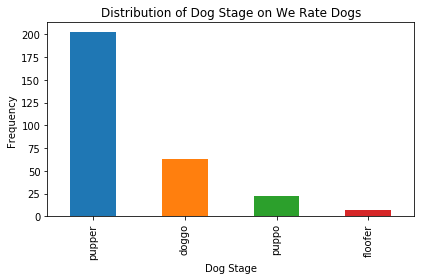

In [100]:
ax = tweets2['dog_stage'].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Distribution of Dog Stage on We Rate Dogs")
ax.set_xlabel("Dog Stage")
ax.set_ylabel("Frequency");

plt.tight_layout() # ensure x axis labels are not cut off jpg
plt.savefig("dog_dist.jpg") # save as jpg

# Insight: Far more puppers in the sample of data.

In [101]:
# analyse the rating of each dog stage
tweets2.groupby('dog_stage')['new_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,63.0,1.188889,0.147135,0.8,1.100,1.2,1.3,1.4
floofer,7.0,1.200000,0.115470,1.0,1.150,1.2,1.3,1.3
pupper,203.0,1.071429,0.207463,0.3,1.000,1.1,1.2,2.7
puppo,22.0,1.200000,0.130931,0.9,1.125,1.2,1.3,1.4


In [102]:
# analyse the favorite count of each dog stage
tweets2.groupby('dog_stage')['favorite_count'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,63.0,20151.396825,27214.604220,2487.0,7965.00,11896.0,19829.0,165012.0
floofer,7.0,12731.428571,10875.334092,2181.0,4835.50,10845.0,17141.5,32140.0
pupper,203.0,7034.359606,11287.687390,665.0,2327.50,3127.0,7385.0,122542.0
puppo,22.0,21901.090909,29910.877964,3143.0,6778.25,12947.0,19081.0,141096.0


In [103]:
# analyse the retweet count of each dog stage
tweets2.groupby('dog_stage')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,63.0,7110.079365,13781.607183,688.0,1917.0,3142.0,5181.0,84187.0
floofer,7.0,4713.714286,5835.703863,475.0,1740.0,3102.0,4209.0,17521.0
pupper,203.0,2263.359606,3589.416017,96.0,657.0,1139.0,2335.0,35679.0
puppo,22.0,6325.272727,10234.124482,671.0,1623.0,2968.5,5964.0,48018.0


In [ ]:
# Insights: Puppers have the lowest ratings on average, but actually the highest 
# rating in the dataset was for a pupper.  
# Puppers also account for the majority of the dogs.
# Puppos have the highest ratings on average but there are fewer of them.

# Puppers also have the lowest favorite count on average and puppos have the highest.
# Doggos have the highest retweet count followed closely by puppos

#### Explore the relationship between ratings and favourite count
- Are they correlated and what is the strength and direction of the correlation? 
- Do higher rated dogs have have a higher favourite count? 
- Show the relationship in a visualisation.

In [104]:
tweets.new_rating.describe()

count    1990.000000
mean        1.170352
std         4.070596
min         0.100000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: new_rating, dtype: float64

In [105]:
# There are some extreme ratings in the dataset.
# I will remove these and retain only up to the 75th percentile.

In [106]:
tweets2 = tweets.query('new_rating <1.2')
tweets2['new_rating'].corr(tweets['favorite_count'])
# Insight: The correlation at 0.19 is not meaningful. 

0.18988363699009694

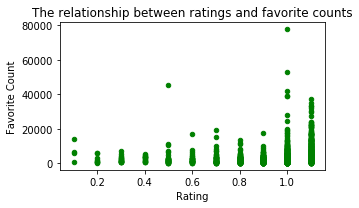

In [107]:
tweets.query('new_rating <1.2').plot(x='new_rating', y='favorite_count', kind='scatter',
                                    color='green', figsize=(5,3))
plt.title('The relationship between ratings and favorite counts')
plt.xlabel('Rating')
plt.ylabel('Favorite Count')
plt.tight_layout()
plt.savefig("ratings_favorites.jpg") # save as jpg
plt.show();


#correlation (0.19) but that the relationship is positive
# Insight: The plot shows that there is a positive relationship - favorite counts increase 
# as ratings increase.

#### Explore the relationship between retweet count and favourite count
- Are they correlated and what is the strength and direction of the correlation?
- Are tweets that are retweeted more, tend to be favourited more?
- Show the relationship in a visualisation.

In [108]:
tweets2 = tweets.query('new_rating <1.2')
tweets2['retweet_count'].corr(tweets['favorite_count'])
# Insight: Retweet Count and Favourite count have a high positive correlation of 0.93. 

0.9277439234871706

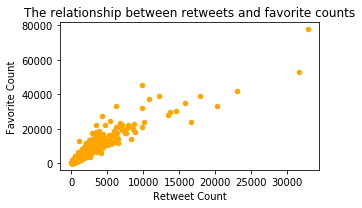

In [109]:
tweets.query('new_rating <1.2').plot(x='retweet_count', y='favorite_count', kind='scatter',
                                    color='orange', figsize=(5,3))
plt.title('The relationship between retweets and favorite counts')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.tight_layout()
plt.savefig("retweets_favorites.jpg") # save as jpg
plt.show();

# Insight: The plot shows that there is a positive relationship - favorite counts increase 
# as retweets increase which is to be expected.

#### Dog breed analysis
- What are the 10 most common breeds on we rate dogs?
- Which breeds are retweeted most?
- Which breeds have the highest confidence levels? 

In [110]:
# print 10 most common breeds
top_breeds = all_data.groupby('prediction_1').size().sort_values(ascending=False).head(10)
top_breeds

prediction_1
Golden Retriever      138
Labrador Retriever     95
Pembroke               88
Chihuahua              79
Pug                    54
Chow                   41
Samoyed                40
Toy Poodle             38
Pomeranian             38
Malamute               29
dtype: int64

In [111]:
# get top 10 in a list to use to query dataframe
breed_list = list(top_breeds.index)

In [112]:
#create dataframe just consisting of 10 most common breeds. 
# @ allows me to refer to variable in the query string.
top_breeds_df = all_data.query('prediction_1 == @breed_list')

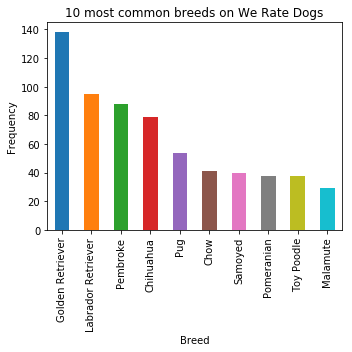

In [113]:
# Now plot the distribution of the top 10 breeds
ax = top_breeds_df['prediction_1'].value_counts().plot(kind='bar',
                                    figsize=(5,5),
                                    title="10 most common breeds on We Rate Dogs")
ax.set_xlabel("Breed")
ax.set_ylabel("Frequency");
plt.tight_layout()
plt.savefig("top_breeds.jpg") # save as jpg

In [ ]:
# Insight: Retrievers are most common breed on We Rate Dogs.  
# True they are a common breed. But is it that they are most easy to classify?

# Now which breeds get the highest retweets?

In [114]:
# first ensure the predictions are valid dog breeds
dog_predictions = all_data.query('p1_dog == True')
# Now get the 10 breeds with the highest average number of retweets
top_retweets = dog_predictions.groupby('prediction_1')['retweet_count'] \
    .mean().sort_values(ascending=False).head(20)
top_retweets

prediction_1
Standard Poodle            6321.714286
English Springer           5692.666667
Afghan Hound               5673.333333
Eskimo Dog                 5219.222222
Saluki                     4875.500000
French Bulldog             4639.640000
Great Pyrenees             4472.857143
Lakeland Terrier           4390.437500
Samoyed                    4374.250000
Cardigan                   4306.470588
Flat-Coated Retriever      4305.875000
Irish Water Spaniel        4273.333333
Tibetan Mastiff            3970.250000
Black-And-Tan Coonhound    3928.000000
Labrador Retriever         3749.168421
Mexican Hairless           3678.000000
Leonberg                   3661.000000
Giant Schnauzer            3632.333333
Cocker Spaniel             3536.740741
Golden Retriever           3490.572464
Name: retweet_count, dtype: float64

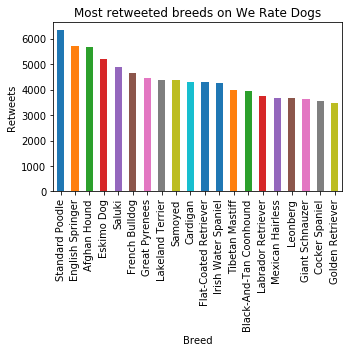

In [115]:
top_retweets.plot(kind='bar',figsize=(5,5))
plt.title('Most retweeted breeds on We Rate Dogs')
plt.xlabel('Breed')
plt.ylabel('Retweets')
plt.tight_layout()
plt.savefig("most_retweeted.jpg") # save as jpg
plt.show();

In [116]:
# Poodles have the highest number of retweets.

# And which breeds get the highest favourite counts?
top_faves = dog_predictions.groupby('prediction_1')['favorite_count'] \
    .mean().sort_values(ascending=False).head(20)
top_faves

prediction_1
Saluki                     23326.500000
French Bulldog             18410.840000
Afghan Hound               16652.000000
Black-And-Tan Coonhound    16438.500000
Flat-Coated Retriever      16236.750000
Irish Water Spaniel        15794.000000
Standard Poodle            15265.857143
English Springer           15145.333333
Cardigan                   14759.588235
Leonberg                   14376.666667
Eskimo Dog                 14322.222222
Basset                     13407.230769
Lakeland Terrier           13299.937500
Border Terrier             13117.000000
Samoyed                    13096.100000
Bedlington Terrier         12566.400000
Great Pyrenees             12431.142857
Mexican Hairless           12230.500000
Golden Retriever           12010.297101
Giant Schnauzer            11961.666667
Name: favorite_count, dtype: float64

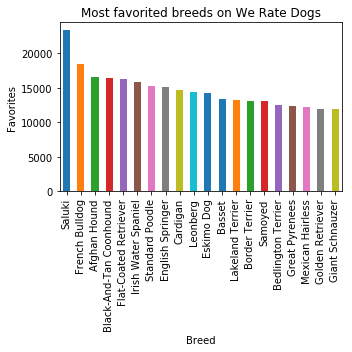

In [117]:
top_faves.plot(kind='bar', figsize=(5,5))
plt.title('Most favorited breeds on We Rate Dogs')
plt.xlabel('Breed')
plt.ylabel('Favorites')
plt.tight_layout()
plt.savefig("most_favorited.jpg") # save as jpg
plt.show();

In [ ]:
# Salukis have the highest favorite counts.

# Explore the relationship between confidence levels and predictions.
# Do neural networks find it easier to predict certain breeds?
# Get the top highest confidence rows from predictions.
# Plot against prediction column

In [118]:
# get the highest and lowest confidence predictions 
top_conf = dog_predictions.groupby('prediction_1')['p1_conf']. \
    mean().sort_values(ascending=False).head(10)
low_conf = dog_predictions.groupby('prediction_1')['p1_conf']. \
    mean().sort_values(ascending=True).head(10)

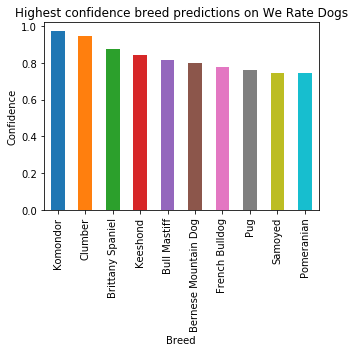

In [119]:
#Plot highest confidence
top_conf.plot(kind='bar', figsize=(5,5))
plt.title('Highest confidence breed predictions on We Rate Dogs')
plt.xlabel('Breed')
plt.ylabel('Confidence')
plt.tight_layout()
plt.savefig("high_conf.jpg") # save as jpg
plt.show();

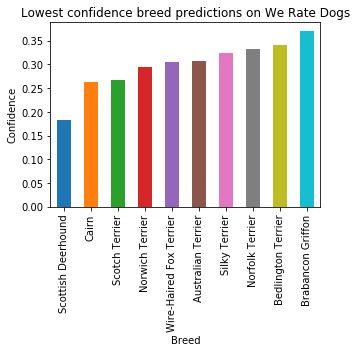

In [120]:
#Plot lowest confidence
low_conf.plot(kind='bar', figsize=(5,5))
plt.title('Lowest confidence breed predictions on We Rate Dogs')
plt.xlabel('Breed')
plt.ylabel('Confidence')
plt.tight_layout()
plt.savefig("low_conf.jpg") # save as jpg
plt.show();

In [ ]:
#The komondor has the highest confidence rate, followed by the clumber.  I wonder if all these
#breeds are distinctive.
#The Scottish deerhound has the lowest confidence, followed by the Cairn.  Interesting that 
#the neural net algorith does not have a high confidence for terriers in general - I wonder if this
#is because there are many different terriers so it could be difficult to distinguish between them.

# Let's look at them.

In [121]:
all_data[(all_data['prediction_1'] == 'Komondor')][['name','jpg_url']]

,name,jpg_url
89,Napolean,https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg
474,Remus,https://pbs.twimg.com/media/Cv3tU38WcAASFas.jpg
1842,NaN,https://pbs.twimg.com/media/CUd5gBGWwAA0IVA.jpg


In [122]:
all_data[(all_data['prediction_1'] == 'Clumber')][['name','jpg_url']]

,name,jpg_url
551,Sophie,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg


In [123]:
all_data[(all_data['prediction_1'] == 'Scottish Deerhound')][['name','jpg_url']]

,name,jpg_url
1160,Freddery,https://pbs.twimg.com/media/CaBP7i9W0AAJrIs.jpg
1402,Louis,https://pbs.twimg.com/media/CWzDWOkXAAAP0k7.jpg
1503,NaN,https://pbs.twimg.com/media/CV_r3v4VAAALvwg.jpg


In [124]:
all_data[(all_data['prediction_1'] == 'Cairn')][['name','jpg_url']]

,name,jpg_url
304,Winston,https://pbs.twimg.com/media/C25d3nkXEAAFBUN.jpg
1100,Calbert,https://pbs.twimg.com/media/CbSqE0rVIAEOPE4.jpg
1766,Butters,https://pbs.twimg.com/media/CU2FsRnVAAA3TEg.jpg


### References
-  https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/

- YouTube: Python Quick Tip: Hiding Passwords and Secret Keys in Environment Variables (Windows) by Corey Schafer.
